In [39]:
%source /opt/ros/noetic/setup.bash

UsageError: Line magic function `%source` not found.


In [76]:
from pathlib import Path
import os
import rospkg
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import re
from tqdm import trange

def load_voxel_grids(file_paths):
    voxel_grids = []
    voxel_size = 0.0075
    grid_size = (40, 40, 40)
    num_files = len(file_paths)
    assert num_files % 2 == 0, "The number of file paths should be even."

    for i in range(0, num_files, 2):

        # Grid 1 is the TSDF as a point cloud 
        grid1 = np.zeros(grid_size)
        pcd1 = o3d.io.read_point_cloud(file_paths[i])
        points1 = np.asarray(pcd1.points)
        distances = np.asarray(pcd1.colors)[:, [0]]
        grid1 = np.zeros((40, 40, 40), dtype=np.float32)
        indices = (points1 // voxel_size).astype(int)
        grid1[tuple(indices.T)] = distances.squeeze()
        # grid1[points1[:, 0], points1[:, 1], points1[:, 2]] = 1
        grid1 = grid1[np.newaxis, :, :, :]
        
        # Grid 2 is the occluded voxel locations
        grid2 = np.zeros(grid_size)
        pcd2 = o3d.io.read_point_cloud(file_paths[i + 1])
        points2 = np.asarray(pcd2.points).astype(int)
        grid2[points2[:, 0], points2[:, 1], points2[:, 2]] = 1
        grid2 = grid2[np.newaxis, :, :, :]

        # Concatenate the two voxel grids along the channel dimension (dim=0)
        combined_grid = np.concatenate((grid1, grid2), axis=0)
        voxel_grids.append(combined_grid)

    return voxel_grids

def split_combined_voxel_grids(combined_grids):
    voxel_grids = []
    for combined_grid in combined_grids:
        # Remove the channel dimension (dim=0) to get the individual voxel grids
        grid1 = combined_grid[0, :, :, :]
        grid2 = combined_grid[1, :, :, :]

        voxel_grids.append(grid1)
        voxel_grids.append(grid2)

    return voxel_grids

# Step 2: Autoencoder Architecture (define the neural network)
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv3d(2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv3d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x = torch.cat((x1, x2), dim=1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Step 3: Training
# Training function
def train_autoencoder(train_data, val_data, num_epochs, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Training on:", device)
    autoencoder = Autoencoder().to(device)
    # use binary cross entropy
    # criterion = nn.MSELoss()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

    train_losses = [] 
    val_losses = []    

    t = trange(num_epochs)
    for epoch in t:
        running_loss = 0.0
        for batch in train_loader:  # Loop through batches in DataLoader
            inputs = batch.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:  # Loop through batches in DataLoader
                inputs = batch.to(device)
                outputs = autoencoder(inputs)
                loss = criterion(outputs, inputs)
                val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        t.set_description(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    plot_autoencoder(train_losses, val_losses)

    return autoencoder

def plot_autoencoder(train, val):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train, label='Train Loss')
    plt.plot(epochs, val, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def encode_voxel_grids(autoencoder, new_voxel_grids):
    # new_voxel_grids = torch.tensor(new_voxel_grids.reshape(-1, 40*40*40), dtype=torch.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    new_voxel_grids = new_voxel_grids.clone().detach().to(device)
    encoded_voxel = autoencoder.encoder(new_voxel_grids)
    return encoded_voxel

def decode_voxel_grids(autoencoder, encoded_voxel):
    decoded_voxel = autoencoder.decoder(encoded_voxel)
    return decoded_voxel

# Function to get file paths for all .pcd files in the specified directory
def get_pcd_file_paths(directory_path):
    file_paths = []
    for filename in os.listdir(directory_path):
        if filename.endswith(".pcd"):
            file_path = os.path.join(directory_path, filename)
            file_paths.append(file_path)
    # Sort the file paths numerically based on the numeric part of the filename
    file_paths.sort(key=lambda x: (int(re.search(r'\d+', x).group()), "occ" in x, x))
    return file_paths

['/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p0_tsdf.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p0_occ.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p1_tsdf.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p1_occ.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p2_tsdf.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p2_occ.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p3_tsdf.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p3_occ.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p4_tsdf.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p4_occ.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p5_tsdf.pcd', '/home/pitcher/dev_ws/thesis_ws/active_search/s

Epoch 100/100, Train Loss: 0.0336, Val Loss: 0.0351: 100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


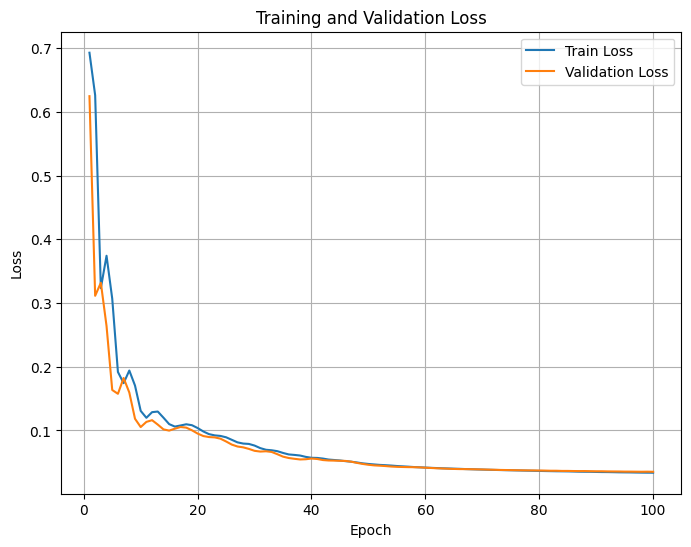

In [77]:
rospack = rospkg.RosPack()
# pkg_root = Path(rospack.get_path("active_search"))
data_folder_path = "/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/"
file_paths = get_pcd_file_paths(data_folder_path)  # List of file paths to your .pcd files
print(file_paths)
voxel_grids = load_voxel_grids(file_paths)

print(voxel_grids[1])

# Convert to PyTorch tensors and flatten the voxel grids
# voxel_tensors = torch.tensor(np.asarray(voxel_grids).reshape(-1, 40*40*40), dtype=torch.float32)
voxel_tensors = torch.tensor(np.asarray(voxel_grids), dtype=torch.float32)
print(voxel_tensors.shape)

num_data = int(voxel_tensors.shape[0]*0.8)
data = voxel_tensors[:num_data]
holdout_data = voxel_tensors[num_data:]

# Split into training and validation sets
num_train_samples = int(data.shape[0]*0.8)
train_data = data[:num_train_samples]
val_data = data[num_train_samples:]

# Define autoencoder parameters
num_epochs = 100
batch_size = 128

# Train the autoencoder
trained_autoencoder = train_autoencoder(train_data, val_data, num_epochs, batch_size)


In [78]:
encoded_voxel = encode_voxel_grids(trained_autoencoder, holdout_data)
decoded_voxel = decode_voxel_grids(trained_autoencoder, encoded_voxel)


print(decoded_voxel.shape)

holdout_grids = split_combined_voxel_grids(holdout_data.cpu().data.numpy())

decoded_grids = split_combined_voxel_grids(decoded_voxel.cpu().data.numpy())
print(len(decoded_grids))
print(holdout_grids)



torch.Size([6, 2, 40, 40, 40])
12
[array([[[0.56078434, 0.70980394, 0.85882354, ..., 0.        ,
         0.        , 0.        ],
        [0.56078434, 0.70980394, 0.85490197, ..., 0.        ,
         0.        , 0.        ],
        [0.56078434, 0.7058824 , 0.8509804 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.5529412 , 0.68235296, 0.8156863 , ..., 0.        ,
         0.        , 0.        ],
        [0.5529412 , 0.68235296, 0.8156863 , ..., 0.        ,
         0.        , 0.        ],
        [0.54901963, 0.6862745 , 0.8156863 , ..., 0.        ,
         0.        , 0.        ]],

       [[0.56078434, 0.70980394, 0.85882354, ..., 0.        ,
         0.        , 0.        ],
        [0.5568628 , 0.7058824 , 0.85490197, ..., 0.        ,
         0.        , 0.        ],
        [0.56078434, 0.7058824 , 0.85490197, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.54901963, 0.68235296, 0.8156863 , ..., 0.        ,
         0.

In [79]:
print(len(voxel_grids))
print(voxel_grids[0].shape)

test_grids = split_combined_voxel_grids(voxel_grids)

print(test_grids[0].shape)


27
(2, 40, 40, 40)
(40, 40, 40)


In [81]:
def to_pcd(grid):
    voxel_size = 0.0075
    threshold = 1e-2
    points = np.argwhere(grid > threshold) #* voxel_size
    # points = np.argwhere(grid > 0) #* voxel_size
    distances = np.expand_dims(grid[grid > threshold], 1)

    

    # non_zero_indices = np.transpose(np.nonzero(decoded_pc_grid))

    # # Convert the non-zero indices to point coordinates
    # point_cloud_coords = non_zero_indices.astype(float)

    # # Create an Open3D point cloud from the coordinates
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    return pcd

active = True

def kill_o3d(sender):
    global active
    active = False

tsdf_exists = False
reset_bb = False

o3d.core.Device("cuda:0")

vis = o3d.visualization.VisualizerWithKeyCallback()

vis.register_key_callback(ord("X"), kill_o3d)

vis.create_window(window_name = "Depth Camera")

print(file_paths[0])

pcd = o3d.io.read_point_cloud(file_paths[0])

test_pcd = to_pcd(test_grids[0])

holdout_pc_grid = holdout_grids[0]
print(holdout_pc_grid.shape)

decoded_pc_grid = decoded_grids[0]


holdout_pcd = to_pcd(holdout_pc_grid)
decode_pcd = to_pcd(decoded_pc_grid)
decode_pcd.translate(np.asarray([0,-41,0]))

frame = o3d.geometry.TriangleMesh.create_coordinate_frame(0.05)

vis.add_geometry(holdout_pcd, reset_bounding_box = True)
vis.add_geometry(decode_pcd, reset_bounding_box = True)
vis.add_geometry(frame, reset_bounding_box = reset_bb)
vis.update_renderer()

while active:

    vis.poll_events()
    vis.update_renderer()

vis.destroy_window()

/home/pitcher/dev_ws/thesis_ws/active_search/src/active_search/training/p0_tsdf.pcd
(40, 40, 40)
